In [359]:
import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the center of mass for TRP rings
def compute_ring_coms(u, trp):
    coms = np.array([[u.atoms.select_atoms(f'(resname TRP and resid {id} and name C1 N1 C2 C3 C4 C5 C6 C7 C8)').center_of_mass()] for id in trp.residues.resids])
    return coms

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    
    delta = pos1 - pos2
    
    delta_x = delta[0]
    delta_y = delta[1]
    delta_z = delta[2]
    
    delta_x -= (round(delta_x/box_length[0])) * box_length[0]
    delta_y -= (round(delta_y/box_length[1])) * box_length[1]
    delta_z -= (round(delta_z/box_length[2])) * box_length[2]
    
    return np.linalg.norm([delta_x, delta_y, delta_z])

# Angle between two vectors using dot product
def compute_angle(vec1, vec2):
    cos_theta = np.dot(vec1, vec2)
    return np.degrees(np.arccos(np.clip(cos_theta, -1, 1)))

# Cross product of two vectors
def compute_cross_product(vec1, vec2):
    return np.cross(vec1, vec2)/np.linalg.norm(np.cross(vec1, vec2))

# Vectors for C1-C4 and C1-C5 for angle calculation
def compute_vectors(trp_res):
    C1 = trp_res.atoms.select_atoms("name C1").positions[0]
    C4 = trp_res.atoms.select_atoms("name C4").positions[0]
    C5 = trp_res.atoms.select_atoms("name C5").positions[0]
    
    vector_C1_C4 = C4 - C1
    vector_C1_C5 = C5 - C1
    return vector_C1_C4, vector_C1_C5


## S0 system angle with 5.5

In [360]:
u = mda.Universe("md_trp_100mM_500ns.tpr", "md_trp_100mM_500ns_pbc_center.xtc")
trp = u.select_atoms("resname TRP")

final_angles = []
for ts in u.trajectory[40000:]:
    angles = []
    coms = compute_ring_coms(u, trp)
    n_rings = len(coms)

    for i in range(0, n_rings-1):
        for j in range(i + 1, n_rings):
            dist = compute_distance(coms[i][0], coms[j][0], u.dimensions[:3])
            # distances.append(dist)
            if dist <= 6.5:  # Distance cutoff 5.5 Å for π-π stacking
                # Vectors for the two indole rings
                vector_C1_C4_1, vector_C1_C5_1 = compute_vectors(trp.residues[i])
                vector_C1_C4_2, vector_C1_C5_2 = compute_vectors(trp.residues[j])
                
                # cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C4_2)
                cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C5_1)
                cross_product2 = compute_cross_product(vector_C1_C4_2, vector_C1_C5_2)

                # dot_product = np.dot(vector_C1_C4_1, vector_C1_C4_2)
                # dot_product = np.dot(cross_product1, cross_product2)
                
                
                # angle = compute_angle(vector_C1_C4_1, vector_C1_C4_2)
                angle = compute_angle(cross_product1, cross_product2)
                angles.append(angle)
    angle_hist = np.histogram(angles, 18, range=(0, 180))[0]
    final_angles.append(angle_hist)

df_angle = pd.DataFrame(final_angles)
avg_final_angles = df_angle.mean(axis=0)



In [361]:
edges = np.histogram([-1], 18, range=(0, 180))[1]
bins = 0.5 * (edges[:-1] + edges[1:])

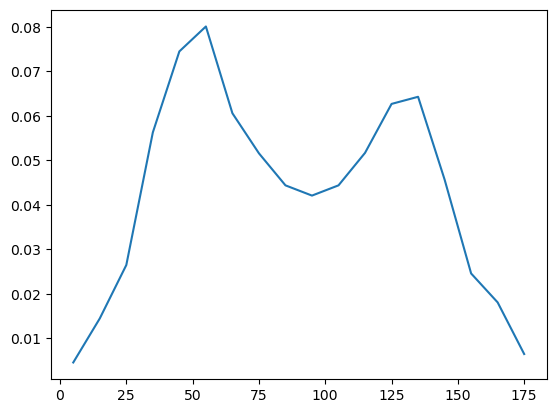

In [362]:
plt.plot(bins, avg_final_angles)

In [364]:
# import pandas as pd
# df_dist=pd.DataFrame(final_distances)
# average_distance = df_dist.mean(axis=0)
# # print(average_dist)
# sns.kdeplot(distances, color="b")
# plt.xlabel('Distance')
# plt.ylabel('Density')
# plt.grid(False)
# plt.show()

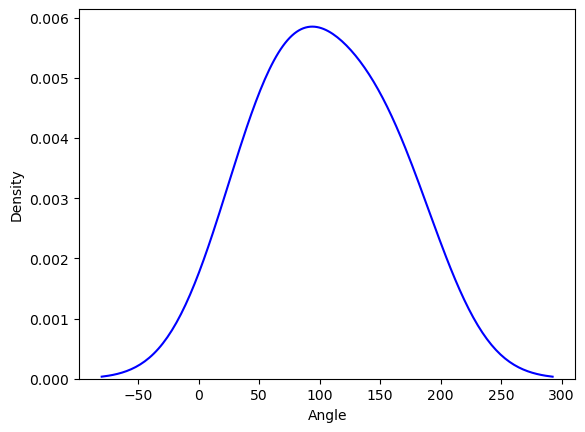

In [365]:
df_angle = pd.DataFrame(final_angles)
average_angle = df_angle.mean(axis=0)
# print(average_angle)
sns.kdeplot(angles, color="b")
plt.xlabel('Angle')
plt.ylabel('Density')
plt.grid(False)
plt.show()

In [366]:
# import seaborn as sns
# from scipy.stats import gaussian_kde
# # Kernel density estimation for 2D histogram
# kde = gaussian_kde(np.vstack([final_distances, final_angles]))
# x = np.linspace(0, 12, 150)
# y = np.linspace(0, 180, 150)
# X, Y = np.meshgrid(x, y)
# Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# # Plot the KDE
# plt.figure(figsize=(8, 6))
# contour = plt.contourf(X, Y, Z, levels=50, cmap='Blues')
# plt.colorbar(contour, label="Density")
# plt.title('KDE Plot of Distance vs Angle for Monomer TRPs')
# plt.xlabel('Distance (Å)')
# plt.ylabel('Angle (degrees)')
# plt.grid(False)
# plt.show()


## S1 system angles

In [367]:

# Input files
TPR = 'md_0_sim_1ta-8trp_addn_sim_500ns.tpr'
XTC = 'md_0_sim_1ta-8trp_addn_sim_500ns_pbc_center.xtc'

# Load the trajectory and topology
u = mda.Universe(TPR, XTC)

# Select TRP and Tannic acids
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname ta")


final_angles1 = []

for ts in u.trajectory[40000:]:  
    angles = []
    trp_coms = [trp.atoms.select_atoms(f'resid {i}').center_of_mass() for i in trp.residues.resids]
    ta_coms = ta.center_of_mass()
    #print(trp_coms, ta_coms)

    # Calculate distances from TA to all TRPs
    dist1 = [compute_distance(i, ta_coms, u.dimensions[:3]) for i in trp_coms]
    # Identify TRPs outside the cutoff (12 Å)
    cutoff_1 = 15
    outside_trps_idxs = np.where(np.array(dist1) >= cutoff_1)[0]

    coms = compute_ring_coms(u, trp)
    
    if (len(outside_trps_idxs) >= 2):
        for i in outside_trps_idxs:
            for j in outside_trps_idxs:
                if j > i:
                    dist = compute_distance(coms[i][0], coms[j][0], u.dimensions[:3])
                    # distances.append(dist)
                    if dist <= 6.5:  # Distance cutoff 5.5 Å for π-π stacking
                        # Vectors for the two indole rings
                        vector_C1_C4_1, vector_C1_C5_1 = compute_vectors(trp.residues[i])
                        vector_C1_C4_2, vector_C1_C5_2 = compute_vectors(trp.residues[j])
                
                        # cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C4_2)
                        cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C5_1)
                        cross_product2 = compute_cross_product(vector_C1_C4_2, vector_C1_C5_2)

                        # dot_product = np.dot(vector_C1_C4_1, vector_C1_C4_2)
                        # dot_product = np.dot(cross_product1, cross_product2)
                
                
                        # angle = compute_angle(vector_C1_C4_1, vector_C1_C4_2)
                        angle = compute_angle(cross_product1, cross_product2)
                        angles.append(angle)
        angle_hist = np.histogram(angles, 18, range=(0, 180))[0]
        final_angles1.append(angle_hist)
        
df_angle = pd.DataFrame(final_angles1)
avg_final_angles1 = df_angle.mean(axis=0)

In [368]:
# k = 0
# for i in outside_trps_idxs[:-1]:
#     for j in outside_trps_idxs[k+1:]:
#         print(i,j)
#         _, dist1 = distances.capped_distance(coms[i][0], coms[j][0], np.inf, box=u.dimensions)
#         dist2 = compute_distance(coms[i][0], coms[j][0], u.dimensions[:3])
#         print(dist1[0], dist2)
#     k += 1

In [369]:
# dist1

(0.0, 180.0)

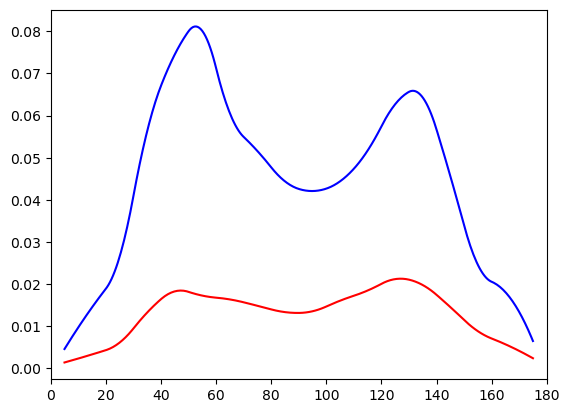

In [370]:
from scipy.interpolate import make_interp_spline, BSpline
bins_new = np.linspace(bins.min(), bins.max(), 300)
spl = make_interp_spline(bins, avg_final_angles, k=2)
spl1 = make_interp_spline(bins, avg_final_angles1, k=2)
plt.plot(bins_new, spl(bins_new), c='blue')
plt.plot(bins_new, spl1(bins_new), c='red')
plt.xlim(0, 180)
#ax.set_yscale('log')

In [371]:

# Input files
TPR = 'md_0_sim_8sbt-8trp_100ns.tpr'
XTC = 'md_0_sim_8sbt-8trp_100ns_pbc_center.xtc'

# Load the trajectory and topology
u = mda.Universe(TPR, XTC)

# Select TRP and Tannic acids
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname SBT")


final_angles2 = []

for ts in u.trajectory[5000:]:  
    angles = []
    trp_coms = [trp.atoms.select_atoms(f'resid {i}').center_of_mass() for i in trp.residues.resids]
    ta_coms = ta.center_of_mass()
    #print(trp_coms, ta_coms)

    # Calculate distances from TA to all TRPs
    dist1 = [compute_distance(i, ta_coms, u.dimensions[:3]) for i in trp_coms]
    # Identify TRPs outside the cutoff (12 Å)
    cutoff_1 = 10
    outside_trps_idxs = np.where(np.array(dist1) >= cutoff_1)[0]

    coms = compute_ring_coms(u, trp)
    
    if (len(outside_trps_idxs) >= 2):
        for i in outside_trps_idxs:
            for j in outside_trps_idxs:
                if j > i:
                    dist = compute_distance(coms[i][0], coms[j][0], u.dimensions[:3])
                    # distances.append(dist)
                    if dist <= 6.5:  # Distance cutoff 5.5 Å for π-π stacking
                        # Vectors for the two indole rings
                        vector_C1_C4_1, vector_C1_C5_1 = compute_vectors(trp.residues[i])
                        vector_C1_C4_2, vector_C1_C5_2 = compute_vectors(trp.residues[j])
                
                        # cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C4_2)
                        cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C5_1)
                        cross_product2 = compute_cross_product(vector_C1_C4_2, vector_C1_C5_2)

                        # dot_product = np.dot(vector_C1_C4_1, vector_C1_C4_2)
                        # dot_product = np.dot(cross_product1, cross_product2)
                
                
                        # angle = compute_angle(vector_C1_C4_1, vector_C1_C4_2)
                        angle = compute_angle(cross_product1, cross_product2)
                        angles.append(angle)
        angle_hist = np.histogram(angles, 18, range=(0, 180))[0]
        final_angles2.append(angle_hist)
        
df_angle = pd.DataFrame(final_angles2)
avg_final_angles2 = df_angle.mean(axis=0)

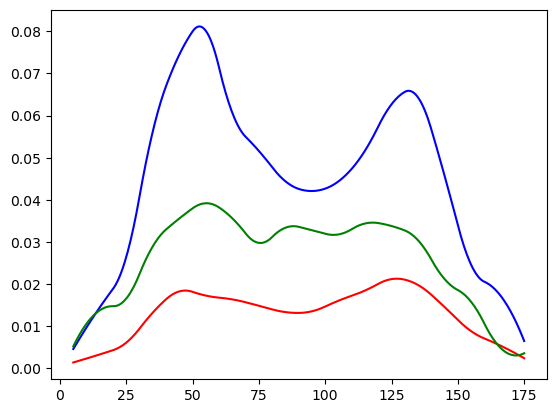

In [372]:
from scipy.interpolate import make_interp_spline, BSpline
bins_new = np.linspace(bins.min(), bins.max(), 300)
spl = make_interp_spline(bins, avg_final_angles, k=2)
spl1 = make_interp_spline(bins, avg_final_angles1, k=2)
spl2 = make_interp_spline(bins, avg_final_angles2, k=2)
plt.plot(bins_new, spl(bins_new), c='blue')
plt.plot(bins_new, spl1(bins_new), c='red')
plt.plot(bins_new, spl2(bins_new), c='green')

In [373]:

# Input files
TPR = 'md_0_sim_8mnt-8trp_100ns.tpr'
XTC = 'md_0_sim_8mnt-8trp_100ns_pbc_center.xtc'

# Load the trajectory and topology
u = mda.Universe(TPR, XTC)

# Select TRP and Tannic acids
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname MNT")


final_angles3 = []

for ts in u.trajectory[5000:]:  
    angles = []
    trp_coms = [trp.atoms.select_atoms(f'resid {i}').center_of_mass() for i in trp.residues.resids]
    ta_coms = ta.center_of_mass()
    #print(trp_coms, ta_coms)

    # Calculate distances from TA to all TRPs
    dist1 = [compute_distance(i, ta_coms, u.dimensions[:3]) for i in trp_coms]
    # Identify TRPs outside the cutoff (12 Å)
    cutoff_1 = 10
    outside_trps_idxs = np.where(np.array(dist1) >= cutoff_1)[0]

    coms = compute_ring_coms(u, trp)
    
    if (len(outside_trps_idxs) >= 2):
        for i in outside_trps_idxs:
            for j in outside_trps_idxs:
                if j > i:
                    dist = compute_distance(coms[i][0], coms[j][0], u.dimensions[:3])
                    # distances.append(dist)
                    if dist <= 6.5:  # Distance cutoff 5.5 Å for π-π stacking
                        # Vectors for the two indole rings
                        vector_C1_C4_1, vector_C1_C5_1 = compute_vectors(trp.residues[i])
                        vector_C1_C4_2, vector_C1_C5_2 = compute_vectors(trp.residues[j])
                
                        # cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C4_2)
                        cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C5_1)
                        cross_product2 = compute_cross_product(vector_C1_C4_2, vector_C1_C5_2)

                        # dot_product = np.dot(vector_C1_C4_1, vector_C1_C4_2)
                        # dot_product = np.dot(cross_product1, cross_product2)
                
                
                        # angle = compute_angle(vector_C1_C4_1, vector_C1_C4_2)
                        angle = compute_angle(cross_product1, cross_product2)
                        angles.append(angle)
        angle_hist = np.histogram(angles, 18, range=(0, 180))[0]
        final_angles3.append(angle_hist)
        
df_angle = pd.DataFrame(final_angles3)
avg_final_angles3 = df_angle.mean(axis=0)

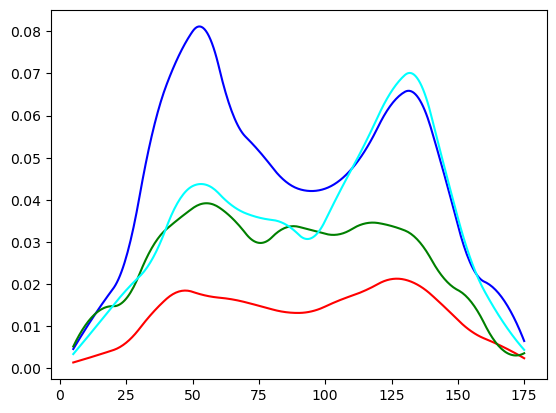

In [380]:
from scipy.interpolate import make_interp_spline, BSpline
bins_new = np.linspace(bins.min(), bins.max(), 300)
spl = make_interp_spline(bins, avg_final_angles, k=2)
spl1 = make_interp_spline(bins, avg_final_angles1, k=2)
spl2 = make_interp_spline(bins, avg_final_angles2, k=2)
spl3 = make_interp_spline(bins, avg_final_angles3, k=2)
plt.plot(bins_new, spl(bins_new), c='blue')
plt.plot(bins_new, spl1(bins_new), c='red')
plt.plot(bins_new, spl2(bins_new), c='green')
plt.plot(bins_new, spl3(bins_new), c='cyan')


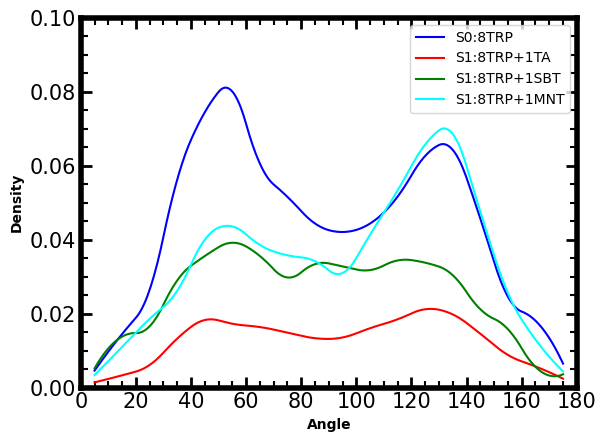

In [389]:
from scipy.interpolate import make_interp_spline, BSpline
bins_new = np.linspace(bins.min(), bins.max(), 300)
spl = make_interp_spline(bins, avg_final_angles, k=2)
spl1 = make_interp_spline(bins, avg_final_angles1, k=2)
spl2 = make_interp_spline(bins, avg_final_angles2, k=2)
spl3 = make_interp_spline(bins, avg_final_angles3, k=2)
plt.plot(bins_new, spl(bins_new), c='blue', label='S0:8TRP')
plt.plot(bins_new, spl1(bins_new), c='red',label='S1:8TRP+1TA')
plt.plot(bins_new, spl2(bins_new), c='green',label='S1:8TRP+1SBT')
plt.plot(bins_new, spl3(bins_new), c='cyan',label='S1:8TRP+1MNT')
plt.legend()
plt.xlabel('Angle',fontweight='bold', fontsize=10)
plt.ylabel('Density',fontweight='bold',fontsize=10)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', length=8, width=3)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='minor', direction='in', length=5, width=1.5)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='major', direction='in', length=8, width=2)
plt.gca().spines['top'].set_linewidth(4)
plt.gca().spines['right'].set_linewidth(4)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['bottom'].set_linewidth(4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,0.1)
plt.xlim(0,180)
plt.savefig('Angle_distribution.png', dpi=1000)
plt.show()

In [244]:
#compute_distance(i, ta_coms[0], u.dimensions[:3]) for i in trp_coms
for i in trp_coms:
    print(i, ta_coms, u.dimensions[:3])

[19.8208532  46.27914632 21.46336531] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]
[ 4.22824888 32.54206855  7.38610278] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]
[45.50988475 11.41528005 25.73917155] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]
[15.48974376 40.85942045 20.70008551] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]
[22.10787547 11.14604916 30.01799574] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]
[25.14599564 17.69006762 36.99470973] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]
[17.28564204 10.90936347 34.36631903] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]
[13.59723824  7.07140908 42.30919515] [19.98698793  7.93933025 38.69312796] [49.507526 49.507526 49.507526]


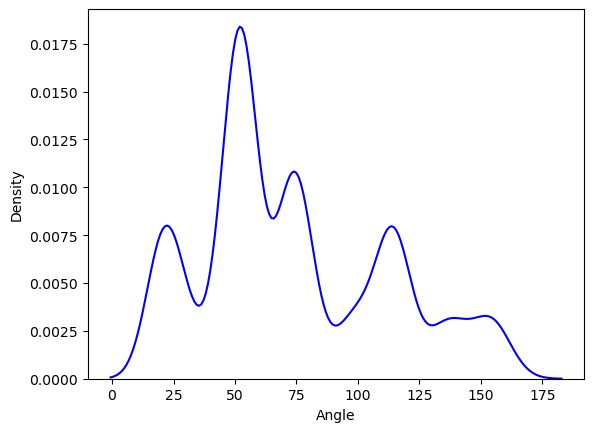

In [21]:
df_angle1 = pd.DataFrame(final_angles1)
average_angle = df_angle1.mean(axis=0)
# print(average_angle)
sns.kdeplot(angles1, color="b")
plt.xlabel('Angle')
plt.ylabel('Density')
plt.grid(False)
plt.show()

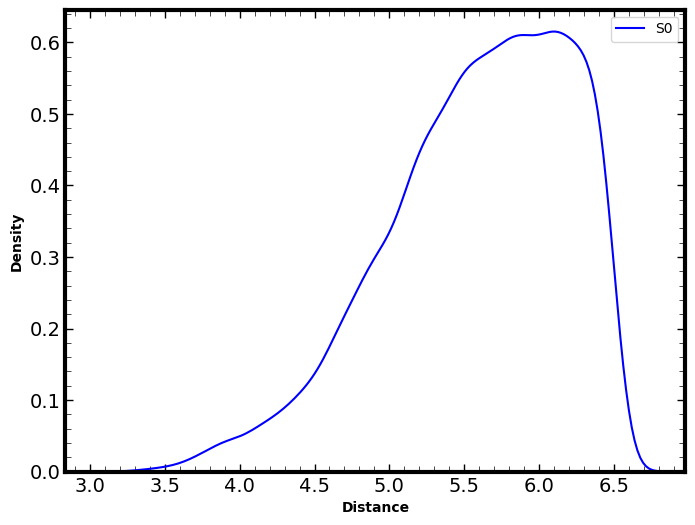

In [22]:
plt.figure(figsize=(8, 6))
sns.kdeplot(distances, color="b",label='S0')
plt.xlabel('Distance',fontweight='bold')
plt.ylabel('Density',fontweight='bold')
plt.legend()

# plt.xticks(ticks=x_values)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', length=8, width=1.5)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=1)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='minor', direction='in', length=4, width=0.5)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='major', direction='in', length=6, width=1)
plt.gca().spines['top'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('TRP-TRP_distance_density_100mM.png', dpi=1000)
plt.show()

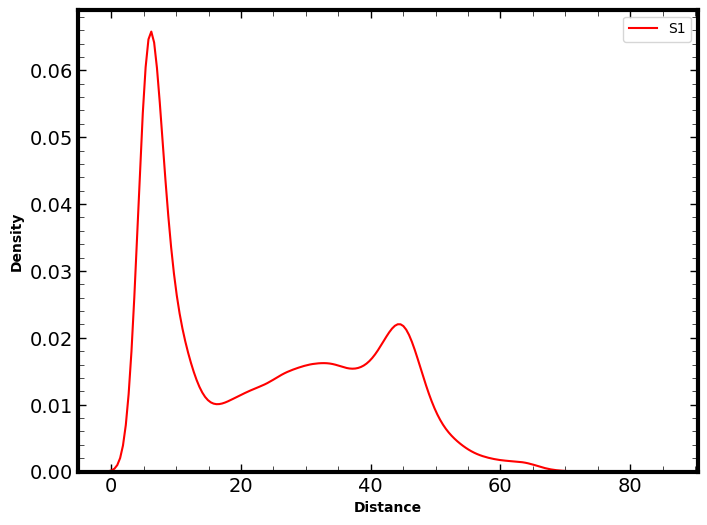

In [23]:

# sns.kdeplot(dist1, color="b")
plt.figure(figsize=(8, 6))
sns.kdeplot(final_distances1, color="r",label='S1')
plt.xlabel('Distance',fontweight='bold')
plt.ylabel('Density',fontweight='bold')
plt.legend()

# plt.xticks(ticks=x_values)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', length=8, width=1.5)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=1)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='minor', direction='in', length=4, width=0.5)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='major', direction='in', length=6, width=1)
plt.gca().spines['top'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('TA-TRP_distance_density_100mM.png', dpi=1000)
plt.show()

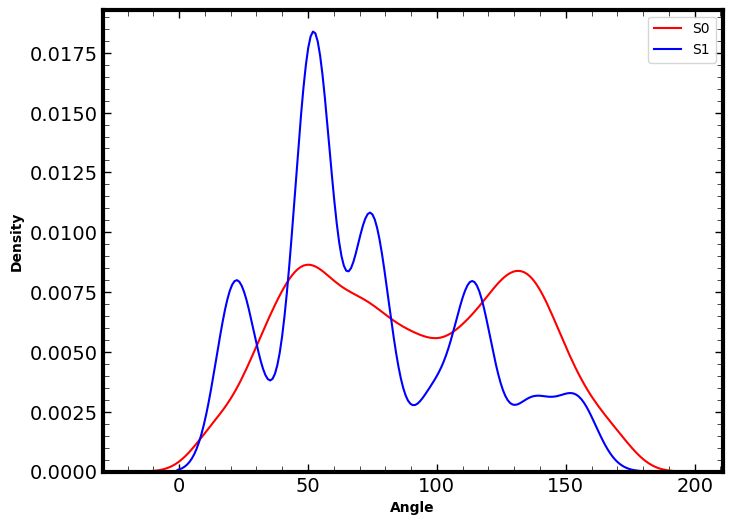

In [24]:
plt.figure(figsize=(8, 6))
sns.kdeplot(angles, color="r",label='S0')
sns.kdeplot(angles1, color="b",label='S1')
plt.xlabel('Angle',fontweight='bold')
plt.ylabel('Density',fontweight='bold')
plt.legend()

# plt.xticks(ticks=x_values)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', length=8, width=1.5)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=1)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='minor', direction='in', length=4, width=0.5)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='major', direction='in', length=6, width=1)
plt.gca().spines['top'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Angle_density_100mM.png', dpi=1000)
plt.show()

In [ ]:
# import MDAnalysis as mda
# import numpy as np
# import matplotlib.pyplot as plt

# TPR = 'md_0_sim_1ta-8trp_addn_sim_500ns.tpr'
# XTC = 'md_0_sim_1ta-8trp_addn_sim_500ns_pbc_center.xtc'


# u = mda.Universe(TPR, XTC)

# trp = u.select_atoms("resname TRP and name C1 N1 C2 C3 C4 C5 C6 C7 C8")
# ta = u.select_atoms("resname ta")

# distances = []

# for ts in u.trajectory[30000:]:  
#     trp_coms = trp.center_of_mass(unwrap=True, compound="fragments")
#     ta_coms = ta.center_of_mass(unwrap=True, compound="fragments")
    
#     for ta_com in ta_coms:
#         dist_to_trp = [np.linalg.norm(ta_com - trp_com) for trp_com in trp_coms]
#         distances.extend(dist_to_trp)

# sns.kdeplot(distances, color='r')
# plt.show()

In [26]:
import MDAnalysis as mda
import numpy as np
from functools import reduce

# Input files
TPR = 'md_0_sim_1ta-8trp_addn_sim_500ns.tpr'
XTC = 'md_0_sim_1ta-8trp_addn_sim_500ns_pbc_center.xtc'

# Load the trajectory and topology
u = mda.Universe(TPR, XTC)

# Select TRP and TA atoms
trp = u.select_atoms("resname TRP and name C1 N1 C2 C3 C4 C5 C6 C7 C8")
ta = u.select_atoms("resname ta")


distances1 = []

for ts in u.trajectory[30000:]:  
    clust_arr = np.zeros(8)

    trp_coms = trp.center_of_mass(unwrap=True, compound="fragments")
    ta_coms = ta.center_of_mass(unwrap=True, compound="fragments")

    # Calculate distances from TA to all TRPs
    dist1 = [np.linalg.norm(i - ta_coms[0]) for i in trp_coms]
    # print(dist1)
    distances1.extend(dist1)
    
final_dist = np.array(distances1) 

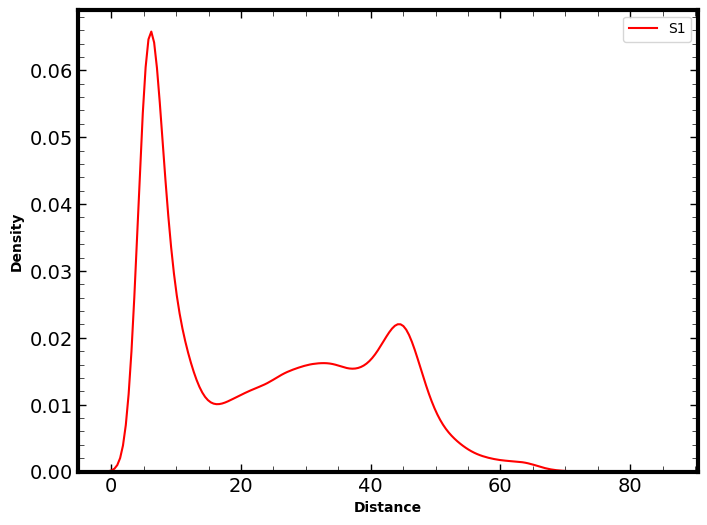

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(8, 6))
sns.kdeplot(final_dist, color="r",label='S1')
plt.xlabel('Distance',fontweight='bold')
plt.ylabel('Density',fontweight='bold')
plt.legend()

# plt.xticks(ticks=x_values)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', length=8, width=1.5)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=1)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='minor', direction='in', length=4, width=0.5)
plt.gca().tick_params(bottom=True, top=True, left=True, right=True,axis='both', which='major', direction='in', length=6, width=1)
plt.gca().spines['top'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('TA-TRP_distance_density_100mM.png', dpi=1000)
plt.show() 

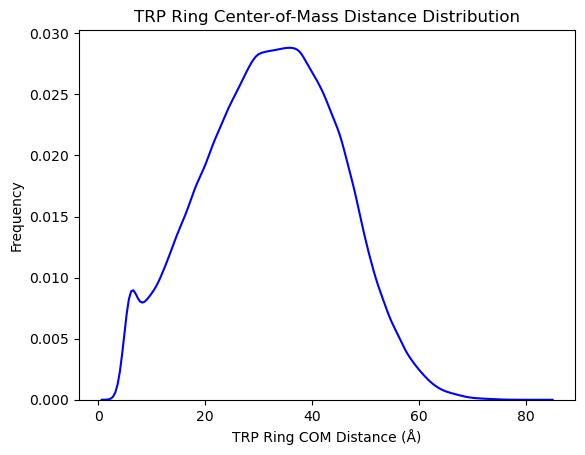

In [29]:
import MDAnalysis as mda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trajectory
u = mda.Universe("md_trp_100mM_500ns.tpr", "md_trp_100mM_500ns_pbc_center.xtc")
trp_rings = u.select_atoms("resname TRP and name C1 N1 C2 C3 C4 C5 C6 C7 C8")

# Calculate the center of mass for TRP rings
def compute_ring_coms(trp_group):
    residues = trp_group.residues
    return [res.atoms.center_of_mass() for res in residues]

# Distance between two centers of mass
def compute_distance(pos1, pos2):
    return np.linalg.norm(pos1 - pos2)

distances = []

for ts in u.trajectory[30000:]: 
    coms = compute_ring_coms(trp_rings)
    n_rings = len(coms)
  
    for i in range(n_rings):
        for j in range(i + 1, n_rings):  
            distances.append(compute_distance(coms[i], coms[j]))

# sns.histplot(distances, bins=50, kde=True)
sns.kdeplot(distances,color='b')
plt.xlabel("TRP Ring COM Distance (Å)")
plt.ylabel("Frequency")
plt.title("TRP Ring Center-of-Mass Distance Distribution")
plt.show()


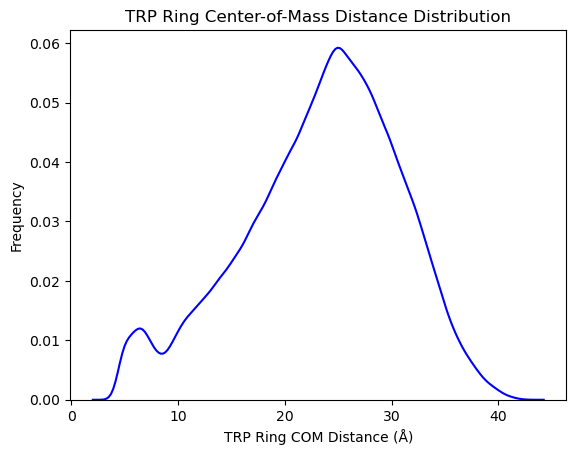

In [60]:
import MDAnalysis as mda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trajectory
u = mda.Universe("md_trp_100mM_500ns.tpr", "md_trp_100mM_500ns_pbc_center.xtc")
trp = u.atoms.select_atoms("resname TRP")

# Calculate the center of mass for TRP rings
def compute_ring_coms(trp):
    coms = np.array([[u.atoms.select_atoms(f'(resid {id} and name C1 N1 C2 C3 C4 C5 C6 C7 C8)').center_of_mass()] for id in trp.residues.resids])
    return coms

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    
    delta = pos1[0] - pos2[0]
    
    delta_x = delta[0]
    delta_y = delta[1]
    delta_z = delta[2]
    
    delta_x -= (round(delta_x/box_length[0])) * box_length[0]
    delta_y -= (round(delta_y/box_length[1])) * box_length[1]
    delta_z -= (round(delta_z/box_length[2])) * box_length[2]
    
    return np.linalg.norm([delta_x, delta_y, delta_z])

distances = []

for ts in u.trajectory[30000:]: 
    coms = compute_ring_coms(trp)
    n_rings = len(coms)
  
    for i in range(0, n_rings-1):
        for j in range(i + 1, n_rings):  
            distances.append(compute_distance(coms[i], coms[j], u.dimensions[:3]))
            
# sns.histplot(distances, bins=50, kde=True)
sns.kdeplot(distances,color='b')
plt.xlabel("TRP Ring COM Distance (Å)")
plt.ylabel("Frequency")
plt.title("TRP Ring Center-of-Mass Distance Distribution")
plt.show()


In [59]:
coms[0][0][0]

40.310182312026356

In [51]:
trp = u.atoms.select_atoms("resname TRP ")
a = [[u.atoms.select_atoms(f'(resid {id} and name C1 N1 C2 C3 C4 C5 C6 C7 C8)').center_of_mass()] for id in np.unique(trp.resids)]
print(a)

[[array([15.86963843, 26.54542828, 12.74909872])], [array([41.21490527, 33.43148045, 25.28183366])], [array([ 4.93579647,  9.73219863, 16.16546249])], [array([ 9.68399258, 36.02147005, 30.29888584])], [array([33.42635731, 34.3956199 , 35.84579959])], [array([33.50147008, 40.3751147 , 30.02053398])], [array([45.37948291, 25.18635514, 13.34454126])], [array([19.1110838 , 21.31783916, 32.81598259])]]


In [33]:
coms = compute_ring_coms(trp_rings)
print(coms)

[array([17.36017257, 26.34104663, 11.73916175]), array([39.70583998, 33.86494689, 24.40078979]), array([ 4.08177504,  8.04406257, 16.4185933 ]), array([ 9.13731049, 34.41358388, 29.57844319]), array([32.00515684, 34.15264454, 37.13542327]), array([32.1925809 , 41.49807186, 30.32469007]), array([44.47514576, 23.55108252, 13.70310119]), array([20.72238822, 21.46011541, 32.27947356])]


In [76]:
outside_trps_idxs[:-1]

array([0, 1, 2, 3, 5])